# PyTorch Workflow - end-to-end

In [2]:
import torch
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
what_were_covering = {
	1: "data (prepare and load)",
	2: "build model",
	3: "fitting the model to data (training)",
	4: "make predictions and evaluate a model (inference)",
	5: "saving and loading a model",
	6: "putting it all together"
}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'make predictions and evaluate a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [8]:
import torch
from torch import nn ## "nn" contains all the building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.0.post3'

## 1. Data (preparing and loading)

In [3]:
# Create parameters for artificial dataset
weight = 0.7
bias = 0.3

# Creata data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

### Splitting in train and test sets

In [4]:
# Create train/test split
train_split = int(0.8 * len(X))
train_split

40

In [5]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
# Visualizing the data
def plot_predictions(train_data=X_train,
					 train_labels=y_train,
					 test_data=X_test,
					 test_labels=y_test,
					 predictions=None):
	"""
	Plots training data, test data and compares predictions.
	"""
	plt.figure(figsize=(10, 7))

	# Training data in blue
	plt.scatter(train_data, train_labels, c='b', s=6, label='Training data')
	plt.scatter(test_data, test_labels, c='g', s=6, label='Testing data')

	if predictions is not None:
		plt.scatter(test_data, predictions, c='r', s=6, label='Predictions')

	plt.legend(prop={'size': 14})

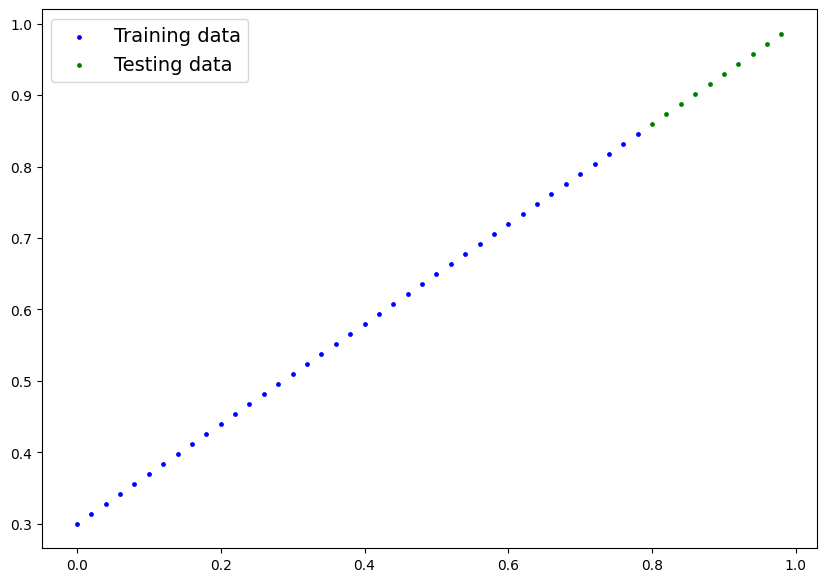

In [18]:
plot_predictions()

## 2. Build model

In [9]:
# Create linear regresion model class
class LinearRegressionModel(nn.Module): # <- almost everything inherits from nn.Module
	def __init__(self):
		super().__init__()
		self.weights = nn.Parameter(torch.randn(1, 
										  requires_grad=True,
										  dtype=torch.float))
		self.bias = nn.Parameter(torch.randn(1,
											 requires_grad=True,
											 dtype=torch.float))
	def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
		return self.weights * x + self.bias


### PyTorch building essentials
* `torch.nn` contains all of the building blocks for computational grapsh (another name for neural networks)
* `torch.nn.Parameter` is what parameters should our model try and learn
* `torch.nn.Module` is base class for all neural network modules, if you subclass it you should override `forward()`
* `torch.optim` is place where optimizers in PyTorch live, they will help with gradient descent
* `def forward()` is needed as `nn.Module()` requires to override this method since it defines what happens in the forward computation 

In [11]:
# Checking the content of the PyTorch model
# Set the random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [98]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`
When the data is passed through the model, it's going to run through the `forward()` method.

In [28]:
# Make predictions
with torch.inference_mode():
	y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

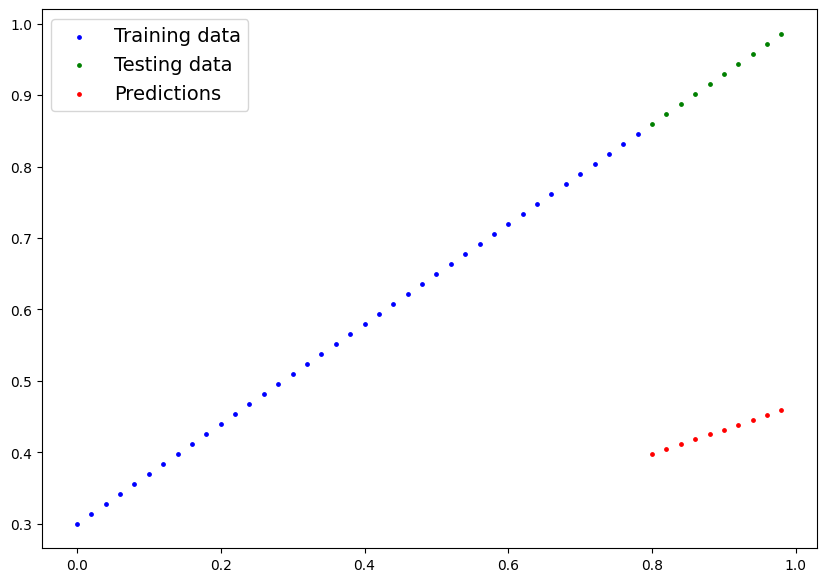

In [29]:
plot_predictions(predictions=y_preds)

## 3. Train model

### Setup a loss function and an optimizer

In [12]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
							lr=0.01)

### Building a training and testing loop
0. Loop through the data
1. Forward pass (involves data moving forward through model) to make predictions -> also called **forward propagation**
2. Calculate the loss (compare predictions from forward pass to ground truth labels)
3. Optimizer zero grad
4. Calculate the loss backwards through the neural network to calculate the gredients of each of the parameters of our model with resepct to the loss -> **backpropagation**
5. Optimizer step uses the optimizer to adjust model's params to try and improve the loss -> **gradient descent**

In [92]:
# Epoch is 1 loop through data
epochs = 1

## Training
# 0. Loop through the data
for epoch in range(epochs):

	# Set model to training model
	model_0.train() # train mode sets all params that require gradients to require gradients

	# 1. Forward pass
	y_pred = model_0(X_train)

	# 2. Calculate the loss
	loss = loss_fn(y_pred, y_train)
	print(f"Step: {epoch}, loss: {loss}")

	# 3. Optimizer zero grad
	optimizer.zero_grad()

	# 4. Perfrom backpropagation on the loss with respect to params of the model
	loss.backward()

	# 5. Step the optimizer (perfrom gradient descent)
	optimizer.step()


	### Testing
	model_0.eval() # turns off gradient tracking

Loss: 0.04272563382983208


In [109]:
# Pretraining
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Updating the training loop with testing part

In [118]:
# Epoch is 1 loop through data
epochs = 100

## TRAINING
# 0. Loop through the data
for epoch in range(epochs+1):

	# Set model to training model
	model_0.train() # train mode sets all params that require gradients to require gradients

	# 1. Forward pass
	y_pred = model_0(X_train)

	# 2. Calculate the loss
	loss = loss_fn(y_pred, y_train)

	# 3. Optimizer zero grad
	optimizer.zero_grad()

	# 4. Perfrom backpropagation on the loss with respect to params of the model
	loss.backward()

	# 5. Step the optimizer (perfrom gradient descent)
	optimizer.step()


	### TESTING
	model_0.eval() # turns off different settings in the model not needed for the evaluation/testing
	with torch.inference_mode(): # <- turns off gradient tracking & a couple more things

		# 1. Do the forward pass
		test_pred = model_0(X_test)

		# 2. Calculate the loss
		test_loss = loss_fn(test_pred, y_test)

	# Print out what's happening
	if epoch % 10 == 0:
		print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
		print(f"Params: {model_0.state_dict()}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Params: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Params: OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Params: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Params: OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Params: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Params: OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Params: OrderedDict

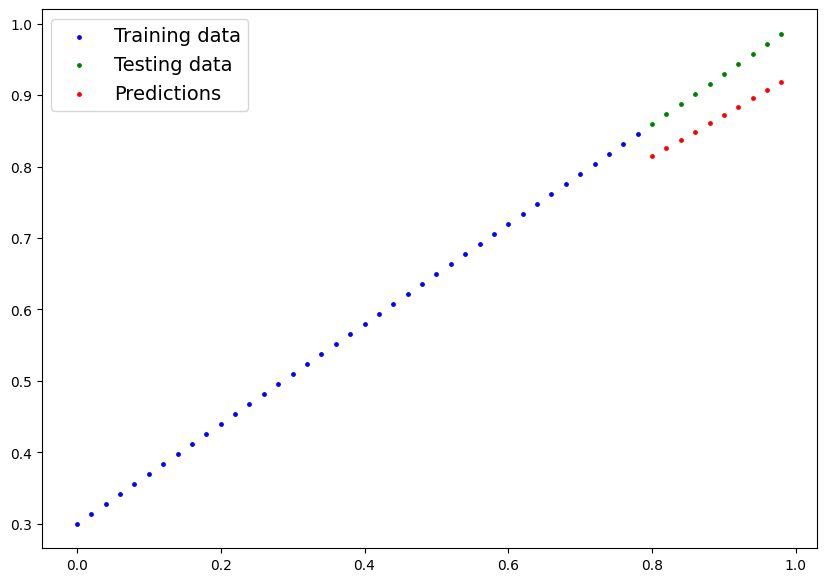

In [119]:
# After 100 epochs
with torch.inference_mode():
	y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Params: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Params: OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Params: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Params: OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Params: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Params: OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Params: OrderedDict

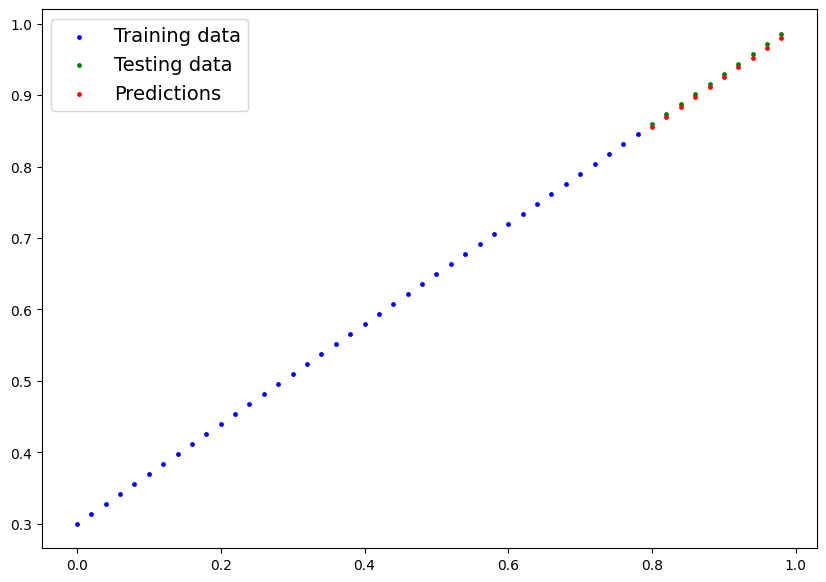

In [122]:
# Epoch is 1 loop through data
epochs = 300

## TRAINING
# 0. Loop through the data
for epoch in range(epochs+1):

	# Set model to training model
	model_0.train() # train mode sets all params that require gradients to require gradients

	# 1. Forward pass
	y_pred = model_0(X_train)

	# 2. Calculate the loss
	loss = loss_fn(y_pred, y_train)

	# 3. Optimizer zero grad
	optimizer.zero_grad()

	# 4. Perfrom backpropagation on the loss with respect to params of the model
	loss.backward()

	# 5. Step the optimizer (perfrom gradient descent)
	optimizer.step()


	### TESTING
	model_0.eval() # turns off different settings in the model not needed for the evaluation/testing
	with torch.inference_mode(): # <- turns off gradient tracking & a couple more things

		# 1. Do the forward pass
		test_pred = model_0(X_test)

		# 2. Calculate the loss
		test_loss = loss_fn(test_pred, y_test)

	# Print out what's happening
	if epoch % 10 == 0:
		print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
		print(f"Params: {model_0.state_dict()}")

# After 300 epochs
with torch.inference_mode():
	y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

### Updating training/testing code with some useful features

In [18]:
# Epoch is 1 loop through data
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

## TRAINING
# 0. Loop through the data
for epoch in range(epochs+1):

	# Set model to training model
	model_0.train() # train mode sets all params that require gradients to require gradients

	# 1. Forward pass
	y_pred = model_0(X_train)

	# 2. Calculate the loss
	loss = loss_fn(y_pred, y_train)

	# 3. Optimizer zero grad
	optimizer.zero_grad()

	# 4. Perfrom backpropagation on the loss with respect to params of the model
	loss.backward()

	# 5. Step the optimizer (perfrom gradient descent)
	optimizer.step()


	### TESTING
	model_0.eval() # turns off different settings in the model not needed for the evaluation/testing
	with torch.inference_mode(): # <- turns off gradient tracking & a couple more things

		# 1. Do the forward pass
		test_pred = model_0(X_test)

		# 2. Calculate the loss
		test_loss = loss_fn(test_pred, y_test)

	# Print out what's happening
	if epoch % 10 == 0:
		epoch_count.append(epoch)
		loss_values.append(loss)
		test_loss_values.append(test_loss)
		
		print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
		print(f"Params: {model_0.state_dict()}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Params: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Params: OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Params: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Params: OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Params: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Params: OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Params: OrderedDict

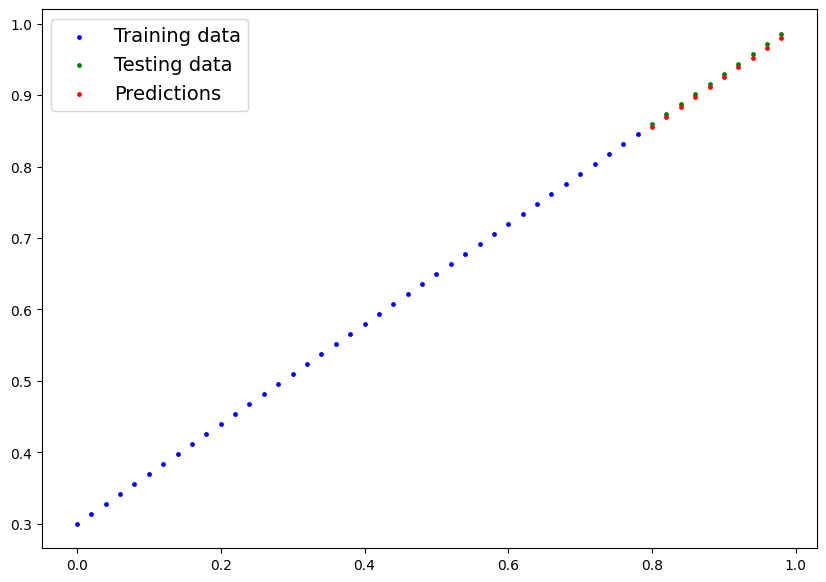

In [19]:
with torch.inference_mode():
	y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

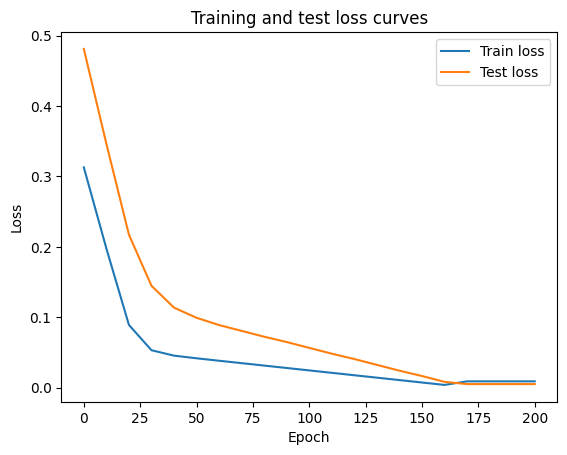

In [137]:
# Plot loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training and test loss curves")
plt.legend()

## Saving a model in PyTorch
There are 3 main methods:
1. `torch.save()` allows to save PyTorch object in Python's pickle format
2. `torch.load()` allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` allows to load model's saved state dictionary

In [20]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model.pth


## Loading a PyTorch model
Since we've saved model's `state_dict()`, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [21]:
# To load in a saved state_dict, we have to instentiate
# a new instance of our class model
loaded_model_0 = LinearRegressionModel()

# Loaded the saved state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

## 6. Putting it all together
Let's go back through the steps above and see it all in one place

In [27]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.0.post3'

In [28]:
# Setup device agnostic code 
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


### 6.1 Data

In [73]:
# Create data using linear regression: y=ax+b
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, dimensionality errors may pop out
y = weight * X + bias
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [74]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

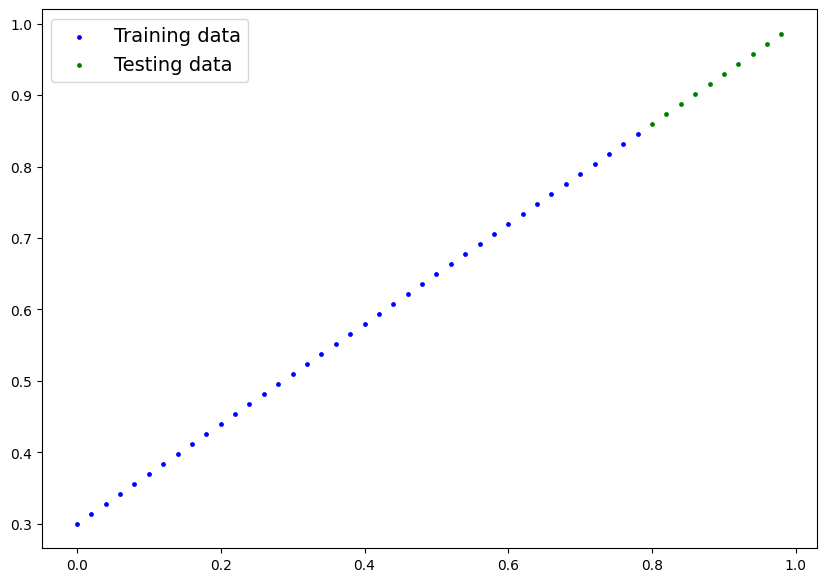

In [75]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

In [84]:
# Create a linear model bu subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
	def __init__(self):
		super().__init__()

		# Use nn.Linear() for creating the model parameters / equivalent of Dense layer from TensorFlow
		self.linear_layer = nn.Linear(in_features=1, # data in
								out_features=1)		 # data out
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.linear_layer(x)

# Set random seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [85]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [86]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

## 6.3 Training
Needed are: 
* loss function
* optimizer
* training loop
* testing loop

In [87]:
# Setup loss function
loss_fn == nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
							lr=0.01)

In [88]:
# Create training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs+1):
	model_1.train()

	# Forward pass
	y_pred = model_1(X_train)

	# Calculate the loss
	loss = loss_fn(y_pred, y_train)

	# Optimizer zero grad
	optimizer.zero_grad()

	# Backpropagation
	loss.backward()

	# Optimizer step
	optimizer.step()

	## Testing
	model_1.eval()
	with torch.inference_mode():
		test_pred = model_1(X_test)
		test_loss = loss_fn(test_pred, y_test)
	
	if epoch % 10 == 0:
		print(f"Epoch: {epoch} | Loss: {loss} | Training loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779270172119 | Training loss: 0.5739762783050537
Epoch: 10 | Loss: 0.4399681091308594 | Training loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Training loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Training loss: 0.16984672844409943
Epoch: 40 | Loss: 0.09433844685554504 | Training loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886388167738914 | Training loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Training loss: 0.04580312594771385
Epoch: 70 | Loss: 0.016517987474799156 | Training loss: 0.0375305712223053
Epoch: 80 | Loss: 0.01308917161077261 | Training loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653176181018353 | Training loss: 0.02167237363755703
Epoch: 100 | Loss: 0.0062156799249351025 | Training loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Training loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645028764382005 | Training loss: 0.013801807537674904
Epoch: 130 | Loss: 

In [89]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='mps:0')),
             ('linear_layer.bias', tensor([0.2925], device='mps:0'))])

In [90]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

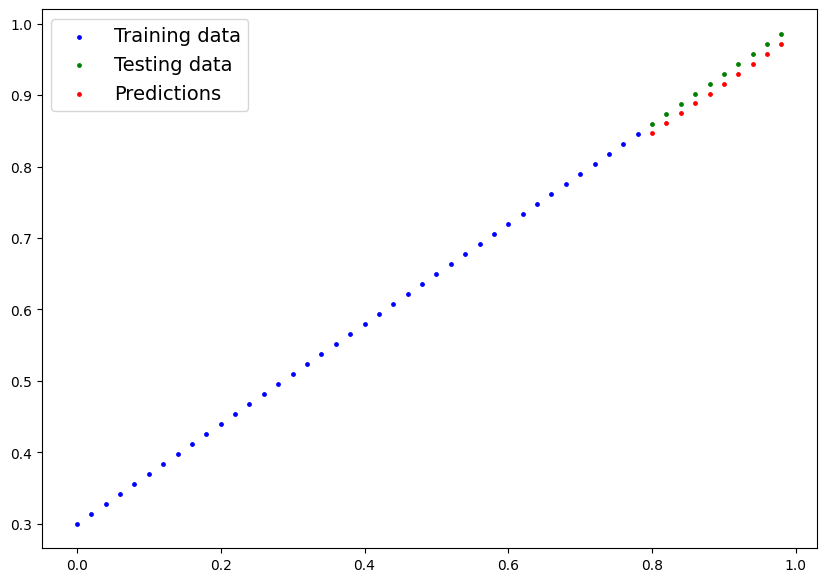

In [91]:
# Plot predictions
model_1.eval()

with torch.inference_mode():
	y_preds = model_1(X_test)
	
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a trained model

In [93]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
		   f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [94]:
# Load a PyTorch module
# Create a new instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model's state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [95]:
next(loaded_model_1.parameters()).device, loaded_model_1.state_dict()

(device(type='mps', index=0),
 OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='mps:0')),
              ('linear_layer.bias', tensor([0.2925], device='mps:0'))]))

In [96]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
	loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')